# Aplicaciones móviles: segmentación de usuarios y usuarias en función del comportamiento (1)

## Introducción 

## Objetivo

Identificar y caracterizar segmentos de usuarios con comportamientos diferenciados en la aplicación, con el fin de optimizar estrategias de engagement, retención y conversión, y comprender las diferencias en el comportamiento de los usuarios provenientes de diferentes canales de adquisición.

### Descomposición de tarea. 



* Carga de librerías 
* Carga de datos
* Exploración inicial de datos
    * Verificar nombres de columnas y tipos de datos
    * Modificar tipos de datos necesarios
    * Comprobación de datos ausentes y datos duplicados
* Ver el espacio de tiempo que abarcan los datos
* Revisión de comportamiento de usuario por evento (primera visita, canal de ingreso, despliegue de número de telefóno de contacto)
* Determinar el orden en que ocurren los eventos (embudo de eventos), hasta el evento objetivo 'contact_show'
* Verificar algunas métricas como: sticky_factor y visitas diarias promedio.
* Calcular las fuentes de adquisición determinando la primera visita. 
* Calcular el tiempo que tardan los usuarios desde su primera visita hasta visitar 'show_contacts' 
* Calculo de evento objetivo por día

## Carga de librerías 

In [1]:
# Importación de librerías 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns


## Carga de datos

In [2]:
# Carga de datos desde carpeta de git
data_path = os.path.join("..", "datasets")

dataset1_path = os.path.join(data_path, "mobile_dataset_us.csv")
dataset2_path = os.path.join(data_path, "mobile_sources_us.csv")

data = pd.read_csv(dataset1_path)
source = pd.read_csv(dataset2_path)

In [3]:
# Carga de datos desde área de trabajo TripleTen

"""data = pd.read_csv("/datasets/mobile_dataset_us.csv")
source = pd.read_csv("/datasets/mobile_sources_us.csv")"""

'data = pd.read_csv("/datasets/mobile_dataset_us.csv")\nsource = pd.read_csv("/datasets/mobile_sources_us.csv")'

## Exploración inicial de datos

### Revisión de tipos de datos y datos ausentes / duplicados

In [4]:
# Revisión de 'data'
print(data.head())
print()
print(data.info())
print()
print("Cantidad de duplicados explícitos:")
print(data.duplicated().sum())
print()
print("Cantidad de datos nulos:")
print(data.isnull().sum())

                   event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None

Cantidad de duplicados explícitos:
0

Cantidad de datos nulos:
event.time    0
event.name    0
user.id       0
dtype

In [5]:
# Cambio en el formato de datos de la columna 'event.time' y creación de columna 'date', tambíen se añaden columnas de semana y mes
data['event.time'] = pd.to_datetime(data['event.time'], unit= 'ns')
data['date'] = data['event.time'].dt.date
data['week'] = data['event.time'].dt.isocalendar().week
data['month'] = data['event.time'].dt.to_period('M').dt.month

Se cambió el formato de la columna 'event.time' para que tuviera formato de fecha (conservando el tiempo) y se agregó una columna 'date' con la fecha de cada evento. 

In [6]:
# Fechas iniciales y finales datos 
print(data['event.time'].min())
print(data['event.time'].max())

2019-10-07 00:00:00.431357
2019-11-03 23:58:12.532487


* Se tiene aproximadamente 1 mes de datos, con datos desde 07 de octubre de 2019, hasta 03 de noviembre de 2019 
* ¿Datos por día serían más relevantes, en comparación con datos semanales?

In [7]:
print(source.head())
print()
print(source.info())
print()
print("Cantidad de duplicados explícitos:")
print(source.duplicated().sum())
print()
print("Cantidad de datos nulos:")
print(source.isnull().sum())

                                 userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c    bing
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3    bing
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None

Cantidad de duplicados explícitos:
0

Cantidad de datos nulos:
userId    0
source    0
dtype: int64


In [8]:
# Se cambia el nombre de la columna 'userId' para que coincida con la columna 'user.id'
source.columns = ['user.id', 'source']

In [9]:
# Fuentes 
source['source'].value_counts()

source
bing      1934
other     1230
google    1129
Name: count, dtype: int64

* Las fuentes principales de búsqueda son bing y google, no se específica en la descripción del dataset a que se refiere 'otros'
* ¿Existe diferencia significativa entre los clientes obtenidos por las principales fuentes? 

In [10]:
# Cantidad de eventos
data['event.name'].value_counts(ascending = False)

event.name
tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: count, dtype: int64

* Existen varios valores ubicados con serch_*, estos datos se pueden agrupar en serch, así como show_contacts y contacts_show que también representan el mismo movimiento. 

In [11]:
# Cambio de valores de la columna 'event.name' para unificar search_*,  show_contacs
data['event.name'] = data['event.name'].replace({
    'search_1': 'search', 
    'search_2': 'search',
    'search_3': 'search',
    'search_4': 'search',
    'search_5': 'search',
    'search_6': 'search',
    'search_7': 'search',
    'contacts_show': 'show_contacts'
})

data['event.name'].value_counts()

event.name
tips_show        40055
photos_show      10012
search            6784
advert_open       6164
show_contacts     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: count, dtype: int64

In [12]:
# Union de la tabla de data con source para obtener datos de fuentes de donde provienen los usuarios 

user_source = pd.merge(data, source, on ='user.id', how ='inner')

# Se comprueba la existencia de valores nulos 
user_source.isnull().sum()

event.time    0
event.name    0
user.id       0
date          0
week          0
month         0
source        0
dtype: int64

In [13]:
# Análisis del comportamiento de usuarios
group_by_users = user_source.groupby(['user.id', 'event.name']).size().reset_index()
group_by_users.columns = ['user.id', 'event.name','count']
group_by_users

,user.id,event.name,count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,6
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,29
2,00157779-810c-4498-9e05-a1e9e3cedf93,advert_open,2
3,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_call,5
4,00157779-810c-4498-9e05-a1e9e3cedf93,favorites_add,2
...,...,...,...
9631,ffe68f10-e48e-470e-be9b-eeb93128ff1a,search,5
9632,ffe68f10-e48e-470e-be9b-eeb93128ff1a,show_contacts,1
9633,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,map,2
9634,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,show_contacts,68


In [14]:
# Análisis de usuario 1
user_1 = user_source[user_source['user.id']== 'ffe68f10-e48e-470e-be9b-eeb93128ff1a'].groupby(['user.id', 'event.name'])
user_1.count()

event.time  date  week  \
user.id                              event.name                              
ffe68f10-e48e-470e-be9b-eeb93128ff1a photos_show             7     7     7   
                                     search                  5     5     5   
                                     show_contacts           1     1     1   

                                                    month  source  
user.id                              event.name                    
ffe68f10-e48e-470e-be9b-eeb93128ff1a photos_show        7       7  
                                     search             5       5  
                                     show_contacts      1       1

In [15]:
# Análisis de usuario 2 
user_2 = user_source[user_source['user.id']== '0001b1d5-b74a-4cbf-aeb0-7df5947bf349'].groupby(['user.id','event.name']).count()
user_2

event.time  date  week  \
user.id                              event.name                           
0001b1d5-b74a-4cbf-aeb0-7df5947bf349 map                  6     6     6   
                                     tips_show           29    29    29   

                                                 month  source  
user.id                              event.name                 
0001b1d5-b74a-4cbf-aeb0-7df5947bf349 map             6       6  
                                     tips_show      29      29

Los usuarios revisados muestran comportamientos muy distintos, con algunas etapas ausentes en uno y en otro. 

In [16]:
data_count_event = user_source.groupby('event.name')['user.id'].agg([
    ('total_events','count'),
    ('unique_users','nunique')]).reset_index().sort_values(by='total_events', ascending= False)
data_count_event

,event.name,total_events,unique_users
8,tips_show,40055,2801
4,photos_show,10012,1095
5,search,6784,1666
0,advert_open,6164,751
6,show_contacts,4529,981
3,map,3881,1456
2,favorites_add,1417,351
7,tips_click,814,322
1,contacts_call,541,213


In [17]:
# Embudo de eventos 
fig = go.Figure(go.Funnel(
    y = data_count_event['event.name'],
    x = data_count_event['total_events'], 
))
fig.update_layout(title= 'Embudo de eventos')
fig.show()

De acuerdo al embudo de eventos, el 11.3% llegan a la etapa  'show_contact', lo que representa un 6.1% del toal. 

In [18]:
data_count_user = data_count_event.sort_values(by= 'unique_users', ascending= False)
data_count_user

,event.name,total_events,unique_users
8,tips_show,40055,2801
5,search,6784,1666
3,map,3881,1456
4,photos_show,10012,1095
6,show_contacts,4529,981
0,advert_open,6164,751
2,favorites_add,1417,351
7,tips_click,814,322
1,contacts_call,541,213


In [19]:
# Embudo por usuarios
fig = go.Figure(go.Funnel(
    y = data_count_user['event.name'],
    x = data_count_user['unique_users'], 
))
fig.update_layout(title= 'Embudo de usuarios')
fig.show()

El 35% de los usuarios iniciales llega a la etapa de 'show_contacts', lo que representa un 10.2% del total. 

Promedio de visitas diarias = user.id    279.18
dtype: float64


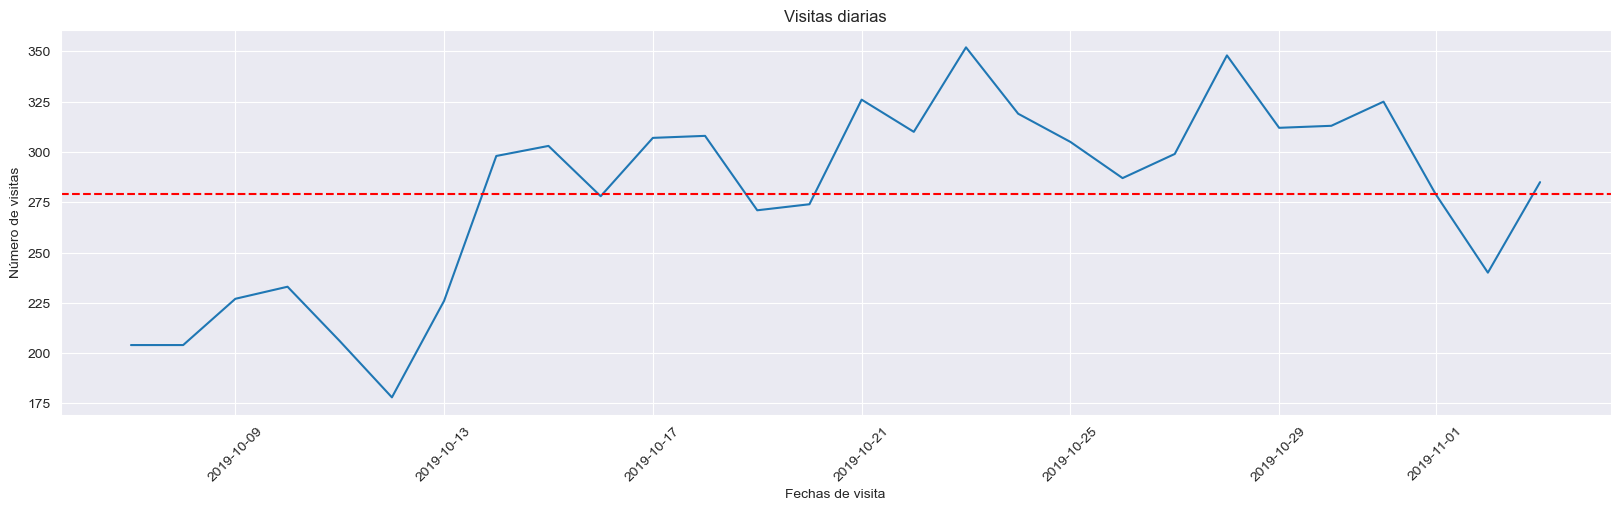

In [20]:
# Visitas diarias a la plataforma 

# Primera visita 
firts_visit = user_source.groupby('user.id')['event.time'].min()
firts_visit.name = 'first_visit_date'
data_first_visit = user_source.merge(firts_visit, on ='user.id')

# Promedio de visitas diarias
visits_dau = np.round(data_first_visit.groupby('date').agg({'user.id':'nunique'}).mean(), 2)
print(f"Promedio de visitas diarias = {visits_dau}")

# Gráfico con visitas dirias 
visits_dau_graph = data_first_visit.groupby('date').agg({'user.id':'nunique'}).reset_index()
daily_mean = visits_dau_graph['user.id'].mean()

sns.set_style('darkgrid')
visits_dau_graph.plot(kind ='line', x='date', y ='user.id', legend = False, figsize=(20,5))
plt.axhline(y = daily_mean, color = 'red', linestyle = '--')
plt.title('Visitas diarias')
plt.xlabel('Fechas de visita')
plt.ylabel('Número de visitas')
plt.xticks(rotation = 45)
plt.show()

In [21]:
# Factor de adherencia semanal y mensual 
visits_wau = data_first_visit.groupby('week').agg({'user.id':'nunique'}).mean()
visits_mau = data_first_visit.groupby('month').agg({'user.id':'nunique'}).mean()

# semanal
sf_week = np.round((visits_dau / visits_wau) * 100, 2)
print(f"Factor de adherencia semanal (%): {sf_week}")

# mensual
sf_month = np.round((visits_dau / visits_mau) * 100, 2)
print(f"Factor de adherencia mensual (%): {sf_month}")


Factor de adherencia semanal (%): user.id    20.19
dtype: float64
Factor de adherencia mensual (%): user.id    12.1
dtype: float64


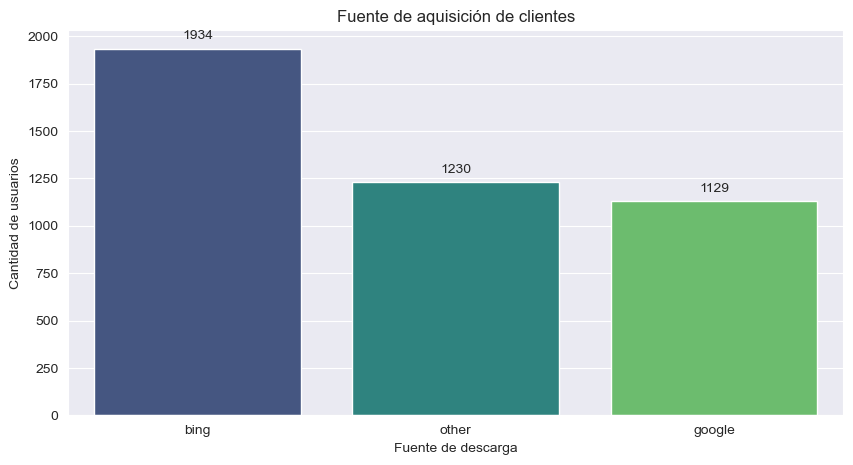

In [22]:
# Análisis de usuarios por fuente de adquisición 
source_adq = data_first_visit.groupby(['first_visit_date', 'source']).agg({'user.id':'nunique'})
source_adq.rename(columns ={'user.id':'count'}, inplace= True)
source_adq.reset_index(inplace= True)
source_only = source_adq.groupby('source').count().sort_values(by='count', ascending = False)


plt.figure(figsize=(10,5))
barplot = sns.barplot(data = source_only, x ='source', y ='count', palette='viridis', hue = 'source')
plt.title('Fuente de aquisición de clientes')
plt.xlabel('Fuente de descarga')
plt.ylabel('Cantidad de usuarios')
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
plt.show()

In [23]:
# Tiempo transcurrido desde primera visita hasta 'show_contacts'

show_contact_data = data_first_visit[data_first_visit['event.name'] == 'show_contacts'].copy()
show_contact_data['visit_to_show_contacts'] = (show_contact_data['event.time'] - show_contact_data['first_visit_date']).dt.total_seconds() / 60
show_contact_data['visit_to_show_contacts'].describe()

count     4529.000000
mean      6200.383554
std       9388.295376
min          0.000000
25%         12.596151
50%        719.528070
75%       9417.013052
max      38666.557504
Name: visit_to_show_contacts, dtype: float64

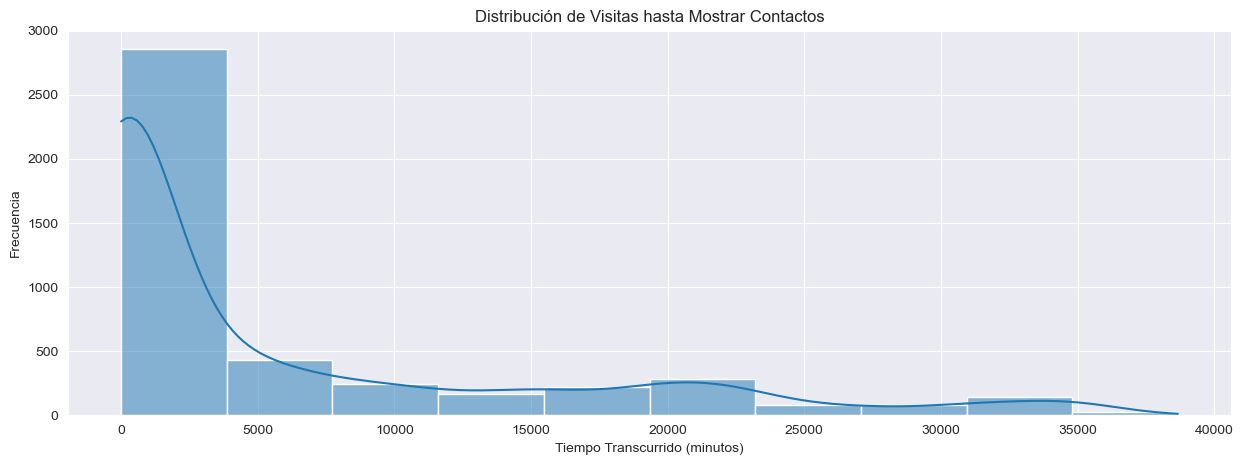

In [24]:
# Gráfico de distribución de los tiempos de conversión expresados en horas 

plt.figure(figsize=(15,5))
sns.histplot(data =show_contact_data, x ='visit_to_show_contacts', bins = 10, kde = True)
plt.title('Distribución de Visitas hasta Mostrar Contactos')
plt.xlabel('Tiempo Transcurrido (minutos)')
plt.ylabel('Frecuencia')
plt.show()


Se observa que muchos ususarios tienden a dirigirse a 'show_contacts' en su primera visita. 

Promedio de show_contact diario: 51.57


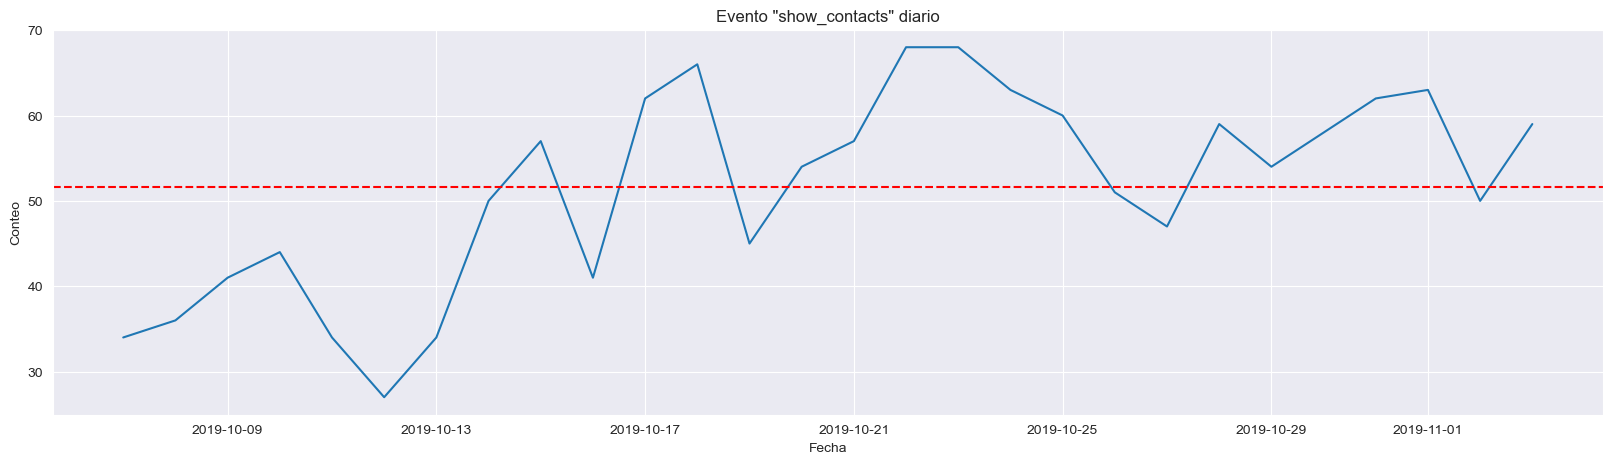

In [26]:
# Gráfico con tendencia de 'show_contact' por día 
# Los datos ya encontraban agrupados por primera visita, y se usó el dataset filtrado por 'show_contacts'

show_contact_dau = show_contact_data.groupby('date').agg({'user.id':'nunique'}).reset_index()
show_contact_mean = show_contact_dau['user.id'].mean().round(2)
print('Promedio de show_contact diario: {}'.format(show_contact_mean))

show_contact_dau.plot(kind= 'line', x= 'date', y ='user.id', legend = False, figsize=(20,5))
plt.axhline(y = show_contact_mean, color = 'red', linestyle = '--')
plt.title('Evento "show_contacts" diario')
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.show()